In [5]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch
import os
import config
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import shutil
import random

from utils import *

In [46]:
# Function to denormalize and convert tensor to numpy for visualization
def tensor_to_img(tensor):
    tensor = tensor * 0.5 + 0.5  # Denormalize
    numpy_img = tensor.numpy()
    return numpy_img.transpose((1, 2, 0))  # Convert from CxHxW to HxWxC

def plot_images(images, labels):
    batch_labels = [config.SELECTED_DOMAIN[l] for l in onehot2label(labels)]
    fig, ax = plt.subplots(1, config.BATCH_SIZE, figsize=(15,5))
    for i in range(int(config.BATCH_SIZE)):
        ax[i].imshow(tensor_to_img(images[i]))
        ax[i].set_title(batch_labels[i]) 
        ax[i].axis('off')

    plt.show()

def count_class_imags(root_dir):
        folder_counts = {}

        for folder_name in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder_name)
            if os.path.isdir(folder_path):
                folder_counts[folder_name] = len(os.listdir(folder_path))

        return folder_counts

In [21]:
def check_label_convertions(images, labels):
    #label_org = stargan_data.get_domain_labels(y)
    label_org = labels
    print(f"original label: \n{label_org}")

    # Generate target domain labels randomly.
    rand_idx = torch.randperm(label_org.size(0))
    label_trg = label_org[rand_idx]

    print(f"target label: {label_trg}")

    c_org = label_org.clone()
    #c_org = label2onehot(label_org, 4)
    #c_trg = label2onehot(label_trg, 4)

    print(f"onehot vector: \n{c_org}")
    print(f"onehot vector shape: {c_org.shape}")

    print(f"img shape: {images.shape}")

    c = c_org.view(c_org.size(0), c_org.size(1), 1, 1)
    c = c.repeat(1, 1, images.size(2), images.size(3))
    images = torch.cat([images, c], dim=1)

    print(f"one-hot-encoded vector label shape: {c.shape}")

    print(f"concatenated img shape: {images.shape}")

# DAWN Dataset

In [ ]:
class DAWNDataset:
    def __init__(self, root, batch_size=32, image_size=128):
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.root_dir = root
        self.dataset = ImageFolder(root=root, transform=self.transform)
        self.data_loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        
        self.domain_map = {
            'Fog':  [1, 0, 0, 0],
            'Rain': [0, 1, 0, 0],
            'Sand': [0, 0, 1, 0],
            'Snow': [0, 0, 0, 1]
        }
        
    def get_dataloader(self):
        return self.data_loader

    def get_domain_labels(self, folder_labels):
        return torch.tensor([self.domain_map[self.dataset.classes[label]] for label in folder_labels])
    
    


In [ ]:
# Create an instance of StarGANDataset
stargan_data = DAWNDataset(root=config.DAWN_DATASET_DIR, batch_size=32, image_size=128)

# Fetch data using the dataloader
data_loader = stargan_data.get_dataloader()

In [ ]:
for images, labels in data_loader:
    print(images.shape)  # Should be [batch_size, 3, 128, 128]
    domain_labels = stargan_data.get_domain_labels(labels)
    print(domain_labels)
    break


In [ ]:
x,y = next(iter(data_loader))

print(f"img_size: {x.shape}")
print(f"labels: {y}")
print(f"first label's onehot encoded vector: {stargan_data.get_domain_labels(labels)[0]}")

In [ ]:
plot_images(x,y,10, dataset=stargan_data.dataset ,dawn=True)

In [ ]:
class_counts = count_class_imags(config.DAWN_DATASET_DIR)
print(class_counts)

In [ ]:
check_label_convertions(x, stargan_data.get_domain_labels(y))

# ACDC Dataset

In [2]:
class ACDCDataset(Dataset):
    def __init__(self, root_dir, selected_conditions=['daytime', 'fog'], transform=None, mode='train'):
        self.root_dir = root_dir
        self.mode = mode
        
        # TODO binary encoding to represent domain information
        # 
        # Define the weather conditions and corresponding labels
        self.selected_conditions = selected_conditions
        self.condition_labels = condition2onehot(selected_conditions)
        print(self.condition_labels)
       
        self.transform = transform

        self.preprocess()

    def preprocess(self):
        # Collect all the image paths and corresponding labels
        self.img_paths = []
        self.labels = []
        for condition in self.selected_conditions:
            condition_path = os.path.join(self.root_dir, condition, self.mode)
            for folder in os.listdir(condition_path):
                if not folder.endswith('_ref'):  # Exclude the '_ref' folders
                    folder_path = os.path.join(condition_path, folder)
                    for img_file in os.listdir(folder_path):
                        if img_file.endswith('.jpg') or img_file.endswith('.png'):  # Assuming images are .jpg or .png
                            self.img_paths.append(os.path.join(folder_path, img_file))
                            self.labels.append(self.condition_labels[condition])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        label = torch.tensor(self.labels[idx])
        return image, label



In [48]:
train_transform = transforms.Compose([
        transforms.Resize(config.IMAGE_SIZE, transforms.InterpolationMode.BILINEAR),  # Resize the smallest side to 128 and maintain aspect ratio
        transforms.RandomCrop(config.IMAGE_SIZE), # is this doing anything ?
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

val_transform = transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE, transforms.InterpolationMode.BILINEAR),  # Resize the smallest side to 128 and maintain aspect ratio
    transforms.RandomCrop(config.IMAGE_SIZE), # is this doing anything ?
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
# Example usage in Jupyter Notebook:
acdc_dataset = ACDCDataset(root_dir=config.ACDC_DATASET_DIR, transform=train_transform, selected_conditions=config.SELECTED_DOMAIN, mode='train')
acdc_dataloader = DataLoader(acdc_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

{'daytime': [1, 0], 'night': [0, 1]}


In [49]:
val_dataset = ACDCDataset(root_dir=config.ACDC_DATASET_DIR, transform=val_transform, selected_conditions=config.SELECTED_DOMAIN, mode='val')
val_dataloader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

{'daytime': [1, 0], 'night': [0, 1]}


In [54]:
images, labels = next(iter(acdc_dataloader))
val_images, val_labels = next(iter(val_dataloader))

In [51]:
print(images.shape)
print(val_images.shape)

torch.Size([4, 3, 128, 128])
torch.Size([4, 3, 128, 128])


In [56]:
print(val_labels)

tensor([[0, 1],
        [1, 0],
        [1, 0],
        [0, 1]])


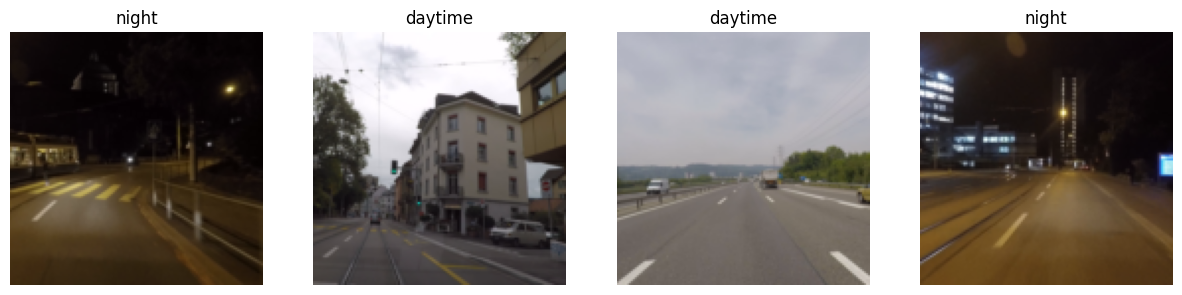

In [57]:
plot_images(val_images, val_labels)

In [58]:
check_label_convertions(val_images, val_labels)

original label: 
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [0, 1]])
target label: tensor([[0, 1],
        [0, 1],
        [1, 0],
        [1, 0]])
onehot vector: 
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [0, 1]])
onehot vector shape: torch.Size([4, 2])
img shape: torch.Size([4, 3, 128, 128])
one-hot-encoded vector label shape: torch.Size([4, 2, 128, 128])
concatenated img shape: torch.Size([4, 5, 128, 128])


In [59]:
print("dataset size: {}".format(len(acdc_dataset)))
print("Each class contains 400 images")

dataset size: 800
Each class contains 400 images
